### 랜덤 포레스트
- 주요 하이퍼 파라미터 (다양하지만 아래 정도의 하이퍼 파라미터 조정으로 대부분 해결 가능)
    - 감소 시킬 수록 모델의 복잡도가 줄어들고 과적합 방지
        - max_depth
        - max_features
        - max_leaf_nodes
    - 증가 시킬 수록 모델의 복잡도가 줄어들고 과적합 방지
        - min_samples_leaf
        - min_samples_split

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier # 잘쓰면 트리모델만큼 좋은게 없다.
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import GridSearchCV # 여러 파라미터를 바꿔가면서 적용시켜 최상의 모델은 구한다
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import graphviz
from sklearn.tree import export_graphviz
import time

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [35]:
# Iris 에 랜덤 포레스트 적용시키기

iris = pd.read_csv("../datas/Iris.csv")

X = iris[["SepalWidthCm","PetalLengthCm","PetalWidthCm"]]
y = iris.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                    random_state=209)

In [36]:
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("x_test: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (120, 3)
x_test:  (30, 3)
x_test:  (120,)
y_test:  (30,)


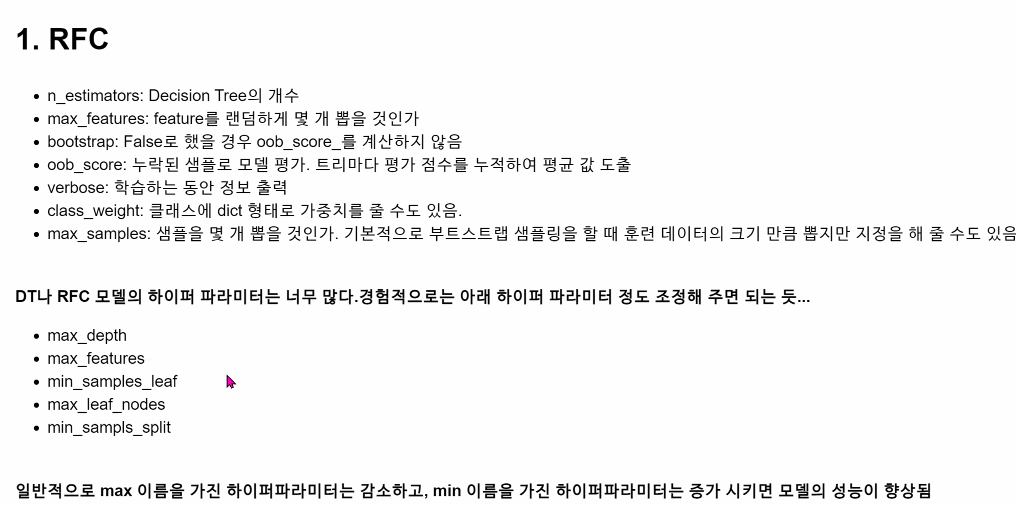

In [37]:
## Random Forest
model_RF = RandomForestClassifier(n_estimators=20,
                                  oob_score=True,
                                  max_depth=2,
                                  random_state=209)

model_RF.fit(x_train,y_train)
pred_RF = model_RF.predict(x_test)

metrics.accuracy_score(pred_RF, y_test)

0.9333333333333333

In [38]:
model_RF.oob_score_ # 뽑히지 않은 데이터로 검증

0.9416666666666667

In [39]:
ooBs = []
estimators = [i for i in range(20,100,10)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators=i,
                                  oob_score=True,
                                  max_depth=2,
                                  random_state=42)
    rfc.fit(x_train,y_train)
    ooBs.append(rfc.oob_score_)

ooBs

[0.9416666666666667,
 0.95,
 0.9416666666666667,
 0.95,
 0.95,
 0.9333333333333333,
 0.9333333333333333,
 0.9166666666666666]

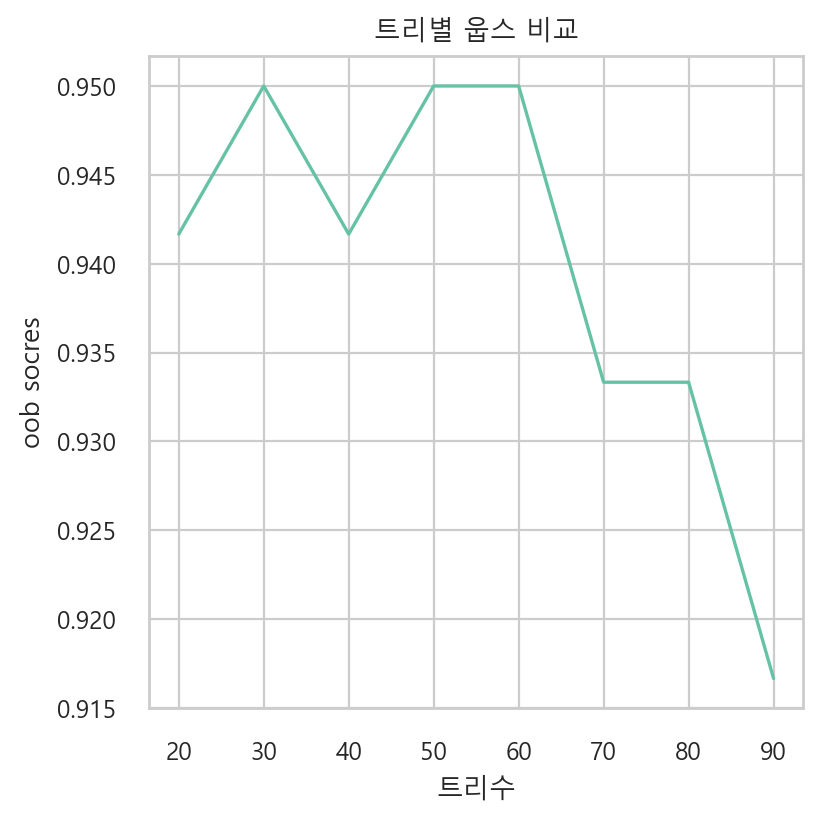

In [40]:
fig, ax = plt.subplots(figsize=(4,4))

sns.lineplot(x =estimators,
             y = ooBs, ax=ax)
ax.set(xlabel="트리수",
       ylabel="oob socres",
       title="트리별 웁스 비교");

## cancer 데이터로 RFC

In [41]:
# np.c_ 와 np.r_ 알아보기

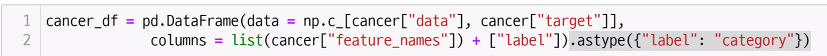

In [42]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(data = np.c_[cancer["data"], cancer["target"]],
             columns = list(cancer["feature_names"]) + ["label"]).astype({"label":"category"})

In [43]:
X = cancer_df[cancer_df.columns[:-1]]
y = cancer_df[cancer_df.columns[-1]]

x_train,x_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)

In [44]:
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
x_test:  (114, 30)
y_train:  (455,)
y_test:  (114,)


In [45]:
## Random Forest
cancer_rfc = RandomForestClassifier(oob_score=True,
                                    random_state=209)

cancer_rfc.fit(x_train,y_train)
pred_cancer_rfc = cancer_rfc.predict(x_test)

metrics.accuracy_score(pred_cancer_rfc, y_test)

0.956140350877193

In [59]:
%%time 
# 타임은 주석 밑에 넣으면 안된다

ooBs = []
estimators = [i for i in range(20,250,10)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators=i,
                                  oob_score=True,
                                  n_jobs=1,
                                  random_state=42)
    rfc.fit(x_train,y_train)
    ooBs.append(rfc.oob_score_)

# ooBs

CPU times: total: 2 s
Wall time: 5.16 s


In [60]:
%%time

ooBs = []
estimators = [i for i in range(20,250,10)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators=i,
                                  oob_score=True,
                                  n_jobs=-1,
                                  random_state=42)
    rfc.fit(x_train,y_train)
    ooBs.append(rfc.oob_score_)

# ooBs

CPU times: total: 1.17 s
Wall time: 4.44 s


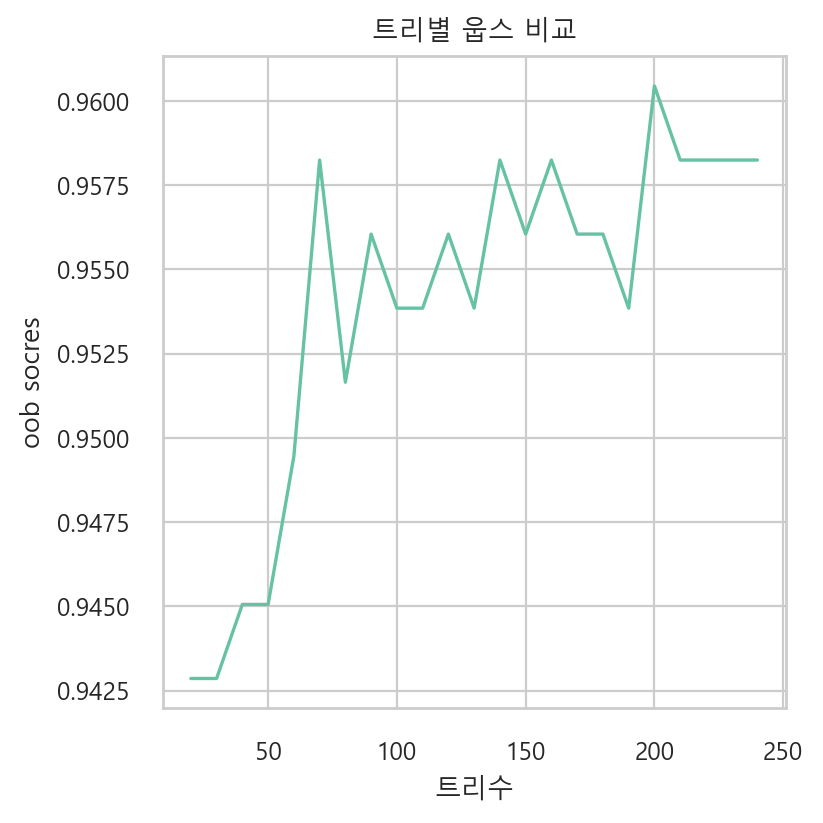

In [61]:
fig, ax = plt.subplots(figsize=(4,4))

sns.lineplot(x =estimators,
             y = ooBs, ax=ax)
ax.set(xlabel="트리수",
       ylabel="oob socres",
       title="트리별 웁스 비교");

In [62]:
def grid_search(params, model_base, njobs = -1):
    model_grid = GridSearchCV(model_base,
                              params,
                              cv=5,
                              return_train_score=True,
                              n_jobs=njobs)

    model_grid.fit(x_train, y_train)

    print("최상 매개변수:", model_grid.best_params_)
    print("최고 정확도:", model_grid.best_score_)
    
    best_model = model_grid.best_estimator_
    best_pred = best_model.predict(x_test)
    print("최고 정확도", metrics.accuracy_score(y_test, best_pred))

params = {
    "max_depth": [None, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [i for i in range(5, 10, 2)],
    "min_samples_split": [4, 8],
}


In [63]:
model = RandomForestClassifier(n_estimators=300,
                               oob_score=True,
                               random_state=209)

In [64]:
%%time

grid_search(params, model,-1)

최상 매개변수: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4}
최고 정확도: 0.9582417582417584
최고 정확도 0.956140350877193
CPU times: total: 703 ms
Wall time: 32 s


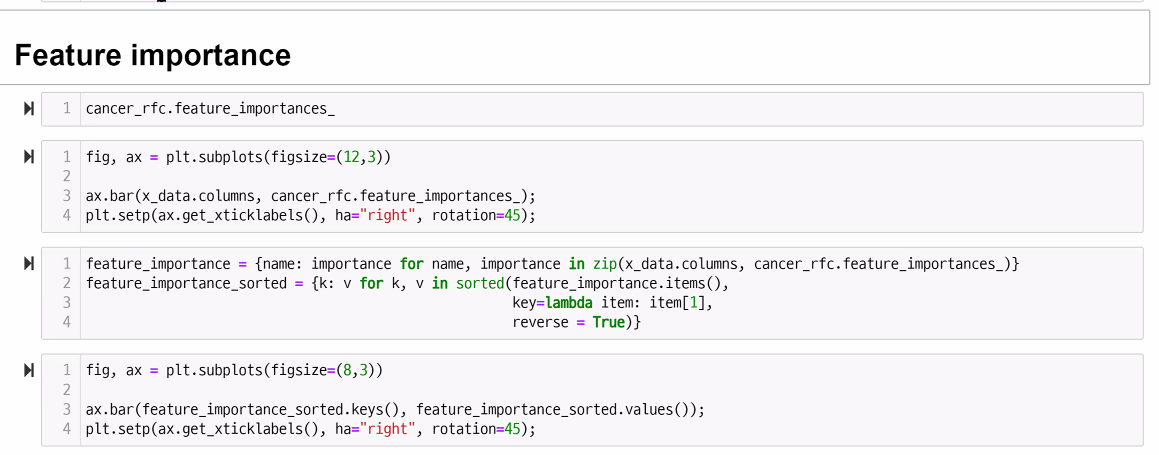

In [65]:
cancer_rfc.feature_importances_

array([0.02257308, 0.01599327, 0.04262345, 0.07988975, 0.00567124,
       0.00804386, 0.05033604, 0.09029945, 0.00290612, 0.00412492,
       0.01627716, 0.00476013, 0.00705572, 0.03173095, 0.00337517,
       0.00508395, 0.00839848, 0.00549689, 0.00380137, 0.00575204,
       0.09331334, 0.02201995, 0.15619003, 0.10022662, 0.01546444,
       0.01633817, 0.05493414, 0.11204959, 0.01115595, 0.00411475])

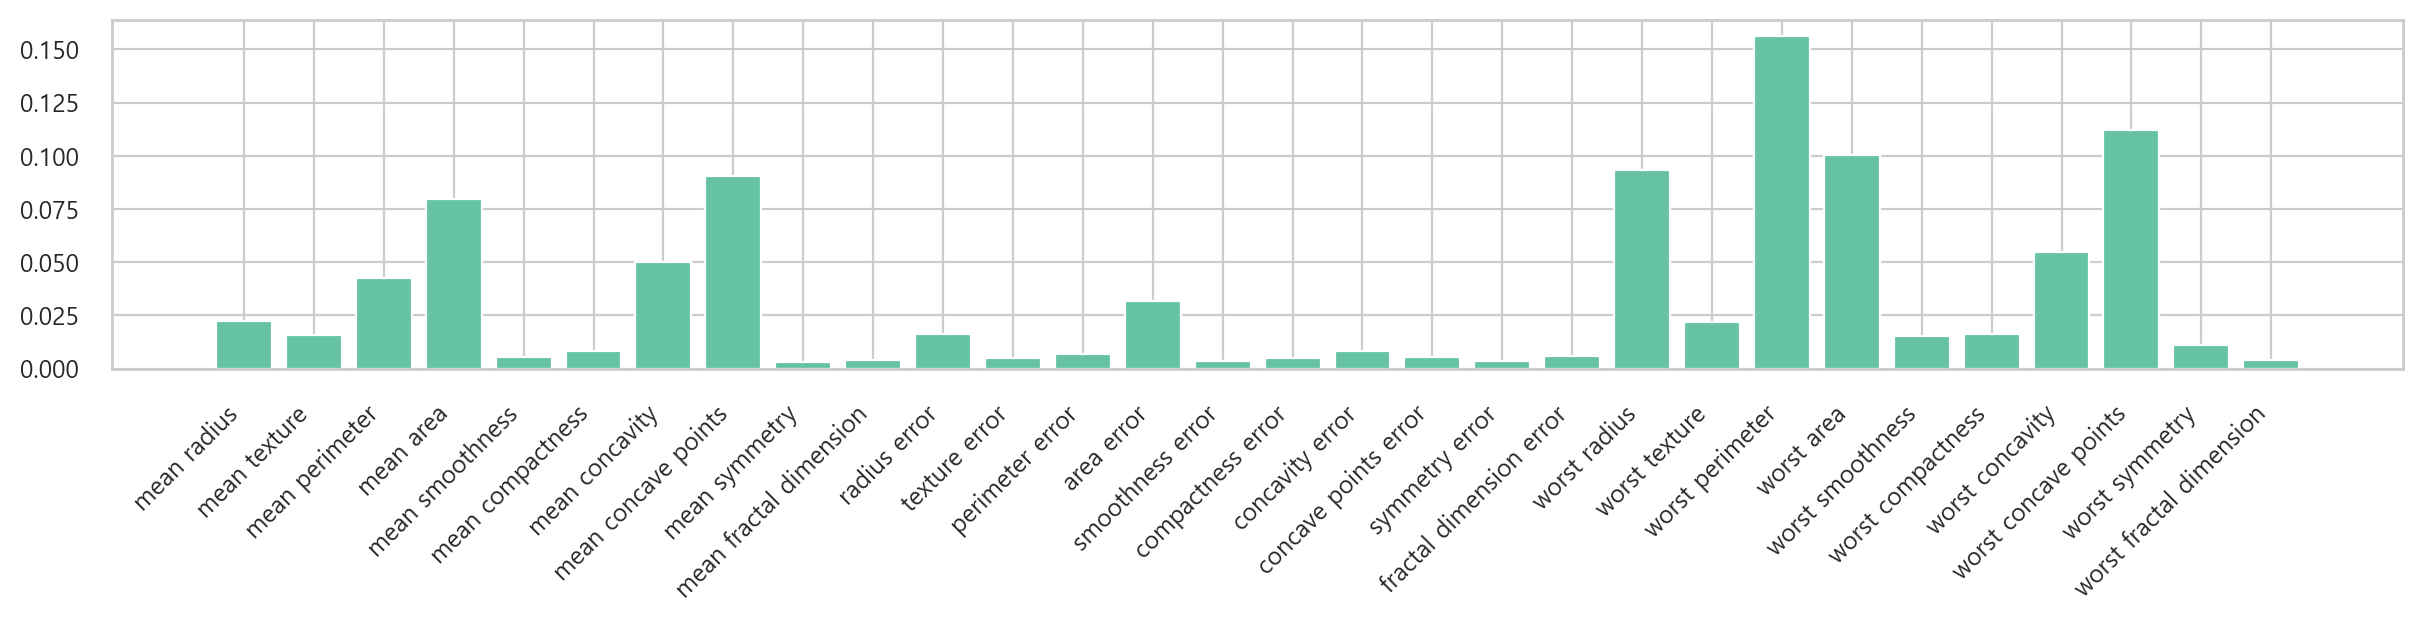

In [53]:
fig, ax = plt.subplots(figsize = (12,3))

ax.bar(X.columns, cancer_rfc.feature_importances_)
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 45);

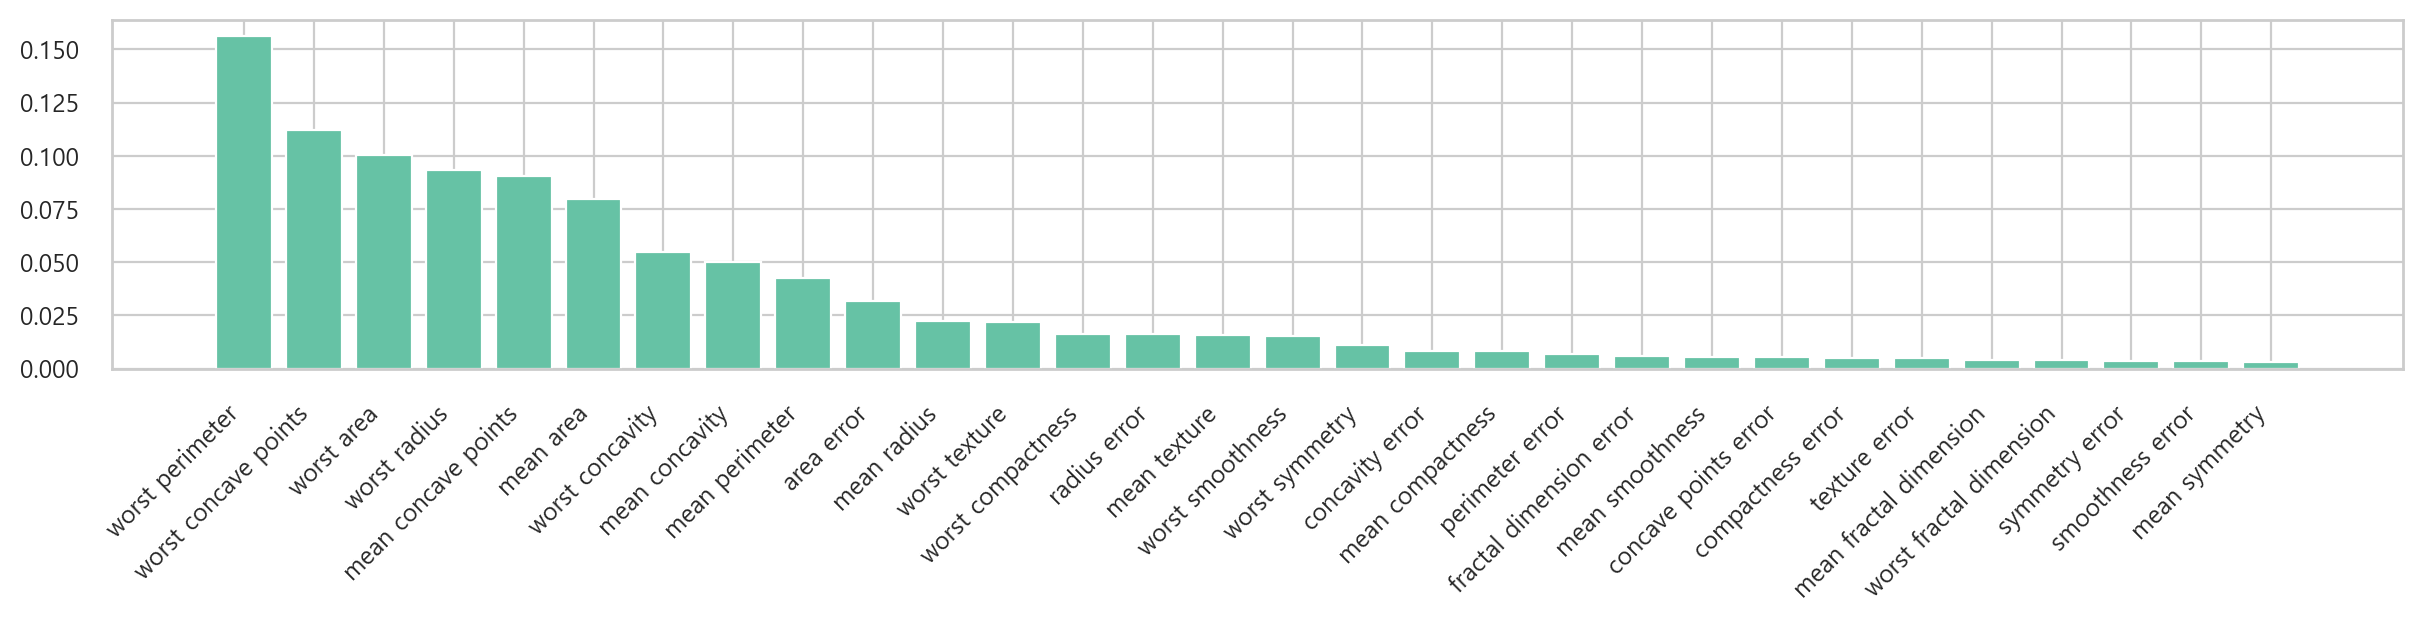

In [54]:
feature_importance = {name: importance for name, importance in zip(X.columns, cancer_rfc.feature_importances_)}
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse = True)}

fig, ax = plt.subplots(figsize = (12,3))

ax.bar(feature_importance_sorted.keys(), feature_importance_sorted.values())
plt.setp(ax.get_xticklabels(), ha = "right", rotation = 45);

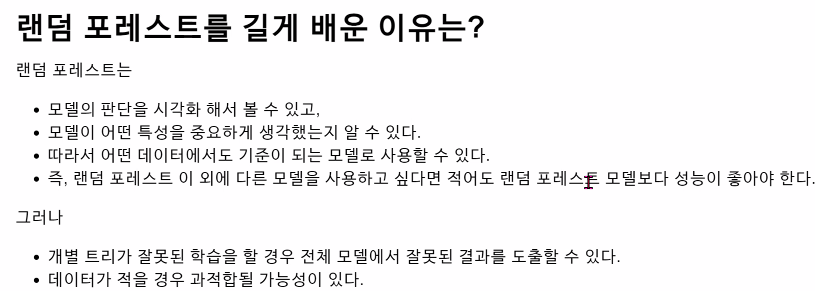

- 트리모델은 스케일링 하지 않아도 된다.
- IG계산 값은 샘플의 갯수를 기준으로 계산하기 때문!
- 다른 모델의 기준이 된다. 즉, 이 랜덤 포레스트보다 더 높은 성능이 되야한다. ( 아니면 그냥 랜덤포레스트를 쓰는게 낫다.)